In [1]:
#import from top directory
import sys
sys.path.append('../')

In [13]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from src.datasets import get_input_transform, get_collate_fn
from src.datasets import Physionet2012
from src.models import GP_Sig
from src.utils.train_utils import count_parameters
from src.training import TrainingLoop
from exp.callbacks import LogTrainingLoss
from torch.utils.data import DataLoader
import gc
import gpytorch
from src.utils.train_utils import augment_labels

In [3]:
# Parameter for test setting:
data_format  = 'GP'
grid_spacing = 1.
device = 'cpu'


## Set up dataset:


In [4]:
#Define dataset transform:
input_transform = get_input_transform(data_format, grid_spacing)
train_dataset = Physionet2012(split = 'training', transform = input_transform)

In [5]:
train_dataset[0].keys()

dict_keys(['values', 'label', 'inputs', 'indices', 'test_inputs', 'test_indices'])

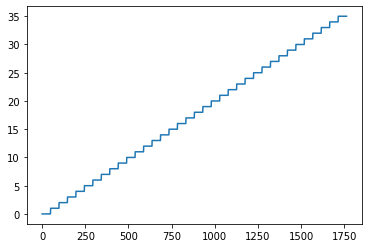

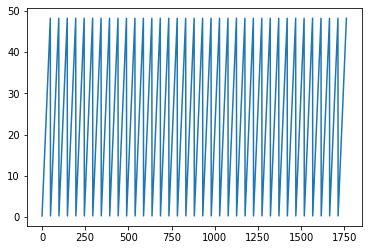

In [178]:
plt.plot(train_dataset[0]['test_indices'])
plt.figure() 
plt.plot(train_dataset[0]['test_inputs'])

## Setting up parameters for Model

In [6]:
#Determine number of input dimensions as GP-Sig models requires this parameter for initialisation
n_input_dims = train_dataset.measurement_dims
out_dimension = train_dataset.n_classes
collate_fn = get_collate_fn(data_format, n_input_dims)
sampling_type = 'monte_carlo'
n_mc_smps = 2 # for debugging
n_devices = 1
output_device = 'cpu'

## Initialize a standard GP-Sig adapter

In [15]:
model = GP_Sig(n_input_dims, 
               out_dimension, 
               sampling_type, 
               n_mc_smps, 
               n_devices, 
               output_device)
model.to(device)
print(f'Number of trainable Parameters: {count_parameters(model)}')

Number of trainable Parameters: 56660


In [16]:
# Loss function:
loss_fn = torch.nn.BCELoss()

# Parameters for Training Loop

In [17]:
n_epochs = 1
batch_size = 32
learning_rate = 0.001
max_root = 25
weight_decay = 1e-3
callbacks = None
virtual_batch_size = None

In [18]:

train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn,
                                  shuffle=False, pin_memory=True, num_workers=8)
n_batches = len(train_loader)
optimizer = torch.optim.Adam(
            model.parameters(), lr=learning_rate,
            weight_decay=weight_decay)
optimizer.zero_grad()

d = list(train_loader)[0]
if n_mc_smps > 1:
    y_true = augment_labels(d['label'], n_mc_smps)
else:
    y_true = d['label']
#GP format of data:
inputs = d['inputs']
indices = d['indices']
values = d['values']
test_inputs = d['test_inputs']
test_indices = d['test_indices']

# Set model into training mode and feed forward
model.train()

with gpytorch.settings.fast_pred_var(), gpytorch.settings.max_root_decomposition_size(max_root):
    logits, Z, Z_raw = model( inputs,
                    indices,
                    values,
                    test_inputs,
                    test_indices)

In [19]:
instance = 2

torch.Size([32, 1764, 1])

In [20]:
#Z_raw[0,0]
first = Z_raw[0,instance].detach().numpy()
first.shape

(1764,)

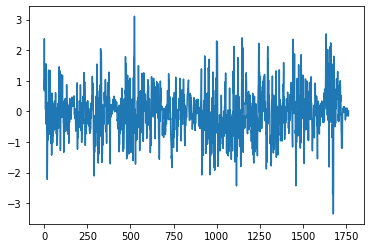

In [21]:
plt.plot(first)

In [22]:
ind = test_indices[2].detach().flatten() # task indices of query points

In [26]:
ind

tensor([ 0,  0,  0,  ..., 36, 36, 36])

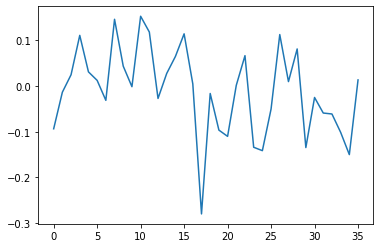

In [24]:
plt.plot(first[ind == 36])

In [30]:
for name, param in model.named_parameters():
    print(name, param)

model.mgp.likelihood.noise_covar.raw_noise Parameter containing:
tensor([0.], requires_grad=True)
model.mgp.mean_module.constant Parameter containing:
tensor([0.], requires_grad=True)
model.mgp.covar_module.raw_lengthscale Parameter containing:
tensor([[0.]], requires_grad=True)
model.mgp.task_covar_module.covar_factor Parameter containing:
tensor([[ 0.5053,  0.8548, -1.7715],
        [-1.5660,  0.0178,  0.1998],
        [-0.3925,  1.0949, -1.1416],
        [ 0.8509, -0.4844,  0.3064],
        [-1.1573,  0.1497,  0.5993],
        [-1.2590,  0.4967, -0.0579],
        [-1.9440, -0.1183,  0.9668],
        [-1.0040,  0.8297,  0.9793],
        [ 0.4514,  0.2294,  0.2831],
        [-1.9003,  0.2023,  0.2990],
        [-2.0812, -1.2225, -0.2196],
        [-0.9411, -0.1549,  1.1830],
        [ 1.2703, -0.0955, -0.5539],
        [ 0.8431,  0.8922, -0.3391],
        [-0.5910, -0.2349, -0.7995],
        [-1.1206, -0.0567, -1.7943],
        [-0.8174,  0.3656,  0.8912],
        [ 0.4556,  0.2787,  

## Do one update step:


In [33]:
y_true = y_true.flatten()
loss = loss_fn(logits, y_true)

# Optimize
optimizer.zero_grad()
loss.backward()
optimizer.step()

/Users/mimoor/.local/share/virtualenvs/GP_Signatures-xG0UHQjJ/lib/python3.7/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


In [40]:
for name, param in model.model.mgp.named_parameters():
    print(name, param)

likelihood.noise_covar.raw_noise Parameter containing:
tensor([0.], requires_grad=True)
mean_module.constant Parameter containing:
tensor([-0.0010], requires_grad=True)
covar_module.raw_lengthscale Parameter containing:
tensor([[-0.0010]], requires_grad=True)
task_covar_module.covar_factor Parameter containing:
tensor([[ 0.5063,  0.8538, -1.7705],
        [-1.5670,  0.0168,  0.2008],
        [-0.3915,  1.0939, -1.1426],
        [ 0.8499, -0.4854,  0.3054],
        [-1.1563,  0.1487,  0.6003],
        [-1.2580,  0.4977, -0.0589],
        [-1.9430, -0.1173,  0.9678],
        [-1.0050,  0.8287,  0.9783],
        [ 0.4504,  0.2284,  0.2821],
        [-1.9013,  0.2013,  0.2980],
        [-2.0802, -1.2215, -0.2186],
        [-0.9421, -0.1559,  1.1840],
        [ 1.2713, -0.0965, -0.5549],
        [ 0.8421,  0.8932, -0.3401],
        [-0.5920, -0.2359, -0.7985],
        [-1.1216, -0.0557, -1.7933],
        [-0.8164,  0.3666,  0.8902],
        [ 0.4566,  0.2777,  0.9346],
        [ 0.6729, -0.

In [43]:
model.model.mgp.task_covar_module.covar_factor

Parameter containing:
tensor([[ 0.5063,  0.8538, -1.7705],
        [-1.5670,  0.0168,  0.2008],
        [-0.3915,  1.0939, -1.1426],
        [ 0.8499, -0.4854,  0.3054],
        [-1.1563,  0.1487,  0.6003],
        [-1.2580,  0.4977, -0.0589],
        [-1.9430, -0.1173,  0.9678],
        [-1.0050,  0.8287,  0.9783],
        [ 0.4504,  0.2284,  0.2821],
        [-1.9013,  0.2013,  0.2980],
        [-2.0802, -1.2215, -0.2186],
        [-0.9421, -0.1559,  1.1840],
        [ 1.2713, -0.0965, -0.5549],
        [ 0.8421,  0.8932, -0.3401],
        [-0.5920, -0.2359, -0.7985],
        [-1.1216, -0.0557, -1.7933],
        [-0.8164,  0.3666,  0.8902],
        [ 0.4566,  0.2777,  0.9346],
        [ 0.6729, -0.9491,  0.2037],
        [-1.1090, -0.6933,  1.3018],
        [-2.2130, -0.3719,  0.7854],
        [-1.0244, -0.4226,  0.2169],
        [-1.4968, -0.9125,  0.1137],
        [-0.3269, -2.3814,  0.9993],
        [-0.0904, -0.0065,  1.2361],
        [-0.8796, -1.6019, -0.2805],
        [ 2.2194

## Plot one instance (Z imputed overlay with Z-raw)

In [14]:
# Exact Hadamard Multi-task Gaussian Process Model
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, output_device, num_tasks=2, n_devices=1, kernel='rbf'):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.output_device = output_device
        self.mean_module = gpytorch.means.ConstantMean()
        valid_kernels = ['rbf', 'ou']
        if kernel not in valid_kernels:
            raise ValueError(f'parsed kernel: {kernel} not among implemented kernels: {valid_kernels}')
        elif kernel == 'rbf':
            base_covar_module = gpytorch.kernels.RBFKernel()
        elif kernel == 'ou':
            base_covar_module = gpytorch.kernels.MaternKernel(nu=0.5)

        if n_devices > 1: #in multi-gpu setting
            self.covar_module = gpytorch.kernels.MultiDeviceKernel(
                base_covar_module, device_ids=range(n_devices),
                output_device=self.output_device)
            #self.task_covar_module = gpytorch.kernels.IndexKernel(num_tasks=num_tasks, rank=3)
            base_task_covar_module = gpytorch.kernels.IndexKernel(num_tasks=num_tasks, rank=3)
            self.task_covar_module = gpytorch.kernels.MultiDeviceKernel(
                base_task_covar_module, device_ids=range(n_devices),
                output_device=self.output_device)
        else:
            self.covar_module = base_covar_module #gpytorch.kernels.RBFKernel()
            self.task_covar_module = gpytorch.kernels.IndexKernel(num_tasks=num_tasks, rank=3)

    def forward(self,x,i):
        mean_x = self.mean_module(x)

        # Get input-input covariance
        covar_x = self.covar_module(x)
        # Get task-task covariance
        covar_i = self.task_covar_module(i)
        # Multiply the two together to get the covariance we want
        covar = covar_x.mul(covar_i)

        return gpytorch.distributions.MultivariateNormal(mean_x, covar)


# MGP Layer for Neural Network using MultitaskGPModel
class MGP_Layer(MultitaskGPModel):
    def __init__(self,likelihood, num_tasks, n_devices, output_device, kernel):
        super().__init__(None, None, likelihood, output_device, num_tasks, n_devices, kernel)
        #we don't intialize with train data for more flexibility
        likelihood.train()

    def forward(self, inputs, indices):
        return super(MGP_Layer, self).forward(inputs, indices)

    def condition_on_train_data(self, inputs, indices, values):
        self.set_train_data(inputs=(inputs, indices), targets=values, strict=False)
        
# Custom GP Adapter:
# MGP Adapter
class GPAdapter(nn.Module):
    def __init__(self, clf, n_input_dims, n_mc_smps, sampling_type, *gp_params):
        super(GPAdapter, self).__init__()
        self.n_mc_smps = n_mc_smps
        # num_tasks includes dummy task for padedd zeros
        self.n_tasks = gp_params[1] - 1
        self.mgp = MGP_Layer(*gp_params)
        self.clf = clf #(self.n_tasks)
        #more generic would be something like: self.clf = clf(n_input_dims) #e.g. SimpleDeepModel(n_input_dims)
        self.sampling_type = sampling_type # 'monte_carlo', 'moments'

    def forward(self, *data):
        """
        The GP Adapter takes input data as a list of 5 torch tensors (3 for train points, 2 for prediction points)
            - inputs: input points of time grid (batch, timesteps, 1)
            - indices: indices of task or channels (batch, timesteps, 1)
            - values: values (or targets) of actual observations (batch, timesteps)
            - test_inputs: query points in time (batch, timesteps, 1)
            - test_indices: query tasks for given point in time (batch, timesteps, 1)
        """
        self.posterior = self.gp_forward(*data)

        #Get regularly-spaced "latent" timee series Z:
        if self.sampling_type == 'monte_carlo':
            #draw sample in MGP format (all tasks in same dimension)
            Z = self.draw_samples(self.posterior, self.n_mc_smps)
        elif self.sampling_type == 'moments':
            #feed moments of GP posterior to classifier (mean, variance)
            Z = self.feed_moments(self.posterior)

        #reshape such that tensor has timesteps and tasks/channels in independent dimensions for Signature network:
        Z, Z_raw = self.channel_reshape(Z)

        return self.clf(Z), Z, Z_raw

    def gp_forward(self, *data):
        #Unpack data:
        inputs, indices, values, test_inputs, test_indices = [*data]

        #Condition MGP on training data:
        self.mgp.condition_on_train_data(inputs, indices, values)

        #Return posterior distribution:
        return self.mgp(test_inputs, test_indices)

    def draw_samples(self, posterior, n_mc_smps):
        #Draw monte carlo samples (with gradient) from posterior:
        return posterior.rsample(torch.Size([n_mc_smps])) #mc_samples form a new (outermost) dimension

    def feed_moments(self, posterior):
        """
        Get mean and variance of posterior and concatenate them along the channel dimension for feeding them to feed the clf
        """
        mean = posterior.mean
        var = posterior.variance
        return torch.cat([ mean, var ], axis=-1)

    def parameters(self):
        return list(self.mgp.parameters()) + list(self.clf.parameters())

    def train(self, mode=True):
        """
        only set classifier to train mode, MGP always in eval mode for posterior draws
        """
        if mode:
            super().train()
            self.mgp.eval()
        else:
            super().train(False)

    def eval(self):
        """
        eval simply calls eval of super class (which in turn activates train with False)
        """
        super().eval()

    def channel_reshape(self, X):
        """
        reshaping function required as hadamard MGP's output format is not directly compatible with subsequent network
        """
        #first check if we have to doubele the number of channels
        if self.sampling_type == 'moments':
            channel_dim = 2*self.n_tasks
        else:
            channel_dim = self.n_tasks

        X_reshaped = X.view(X.shape[:-1]                    #batch-dim (or mc_smp and batch_dim)
            + torch.Size([channel_dim])                     #channel-dim
            + torch.Size([int(X.shape[-1] / channel_dim)])  #time steps dim
        )
        # finally, swap last two dims: timestep and channel dim for Signature Augmentations
        X_reshaped = X_reshaped.transpose(-2,-1)
        
        if self.sampling_type == 'monte_carlo':
            X_reshaped = X_reshaped.flatten(0,1) #SigNet requires 3 dim setup, so we flatten out the mc dimension with batch
        return X_reshaped, X
    
from src.models.deep_models import DeepSignatureModel

class GP_Sig(nn.Module):
    def __init__(self, n_input_dims, out_dimension, sampling_type, n_mc_smps,
            n_devices, output_device, sig_depth=2, kernel='rbf'):
        super(GP_Sig, self).__init__()

        #safety guard:
        self.sampling_type = sampling_type
        if self.sampling_type == 'moments':
            n_mc_smps = 1
            # the classifier receives mean and variance of GPs posterior
            clf_input_dims = 2*n_input_dims
        else:
            clf_input_dims = n_input_dims

        likelihood = gpytorch.likelihoods.GaussianLikelihood().to(
                        output_device, non_blocking=True)
        clf = DeepSignatureModel(   in_channels=clf_input_dims,
                                    out_dimension=out_dimension,
                                    sig_depth=sig_depth
                                )

        self.model = GPAdapter( clf,
                                None,
                                n_mc_smps,
                                sampling_type,
                                likelihood,
                                n_input_dims + 1,
                                n_devices,
                                output_device,
                                kernel
        )

    def forward(self, *data):
        return self.model(*data)

In [74]:
# Custom TrainingLoop:
"""Training classes."""
import gc
import gpytorch
import torch
from torch.utils.data import DataLoader
import numpy as np
from src.utils.train_utils import augment_labels


class CustomTrainingLoop():
    """Training a model using a dataset."""

    def __init__(self, model, dataset, data_format, loss_fn, collate_fn, n_epochs, batch_size, virtual_batch_size, learning_rate,
                 n_mc_smps=1, max_root=25, weight_decay=1e-5, device='cuda', callbacks=None):
        """Training of a model using a dataset and the defined callbacks.

        Args:
            model: GP_Sig, competitor
            dataset: Dataset
            n_epochs: Number of epochs to train
            batch_size: Batch size
            learning_rate: Learning rate
            callbacks: List of callbacks
        """
        self.model = model
        self.dataset = dataset
        self.data_format = data_format
        self.loss_fn = loss_fn
        self.collate_fn = collate_fn
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.virtual_batch_size = virtual_batch_size
        self.learning_rate = learning_rate
        self.n_mc_smps = n_mc_smps
        self.max_root = max_root
        self.weight_decay = weight_decay
        self.device = device
        self.callbacks = callbacks if callbacks else []

    def _execute_callbacks(self, hook, local_variables):
        stop = False
        for callback in self.callbacks:
            # Convert return value to bool --> if callback doesn't return
            # anything we interpret it as False
            stop |= bool(getattr(callback, hook)(**local_variables))
        return stop

    def on_epoch_begin(self, local_variables):
        """Call callbacks before an epoch begins."""
        return self._execute_callbacks('on_epoch_begin', local_variables)

    def on_epoch_end(self, local_variables):
        """Call callbacks after an epoch is finished."""
        return self._execute_callbacks('on_epoch_end', local_variables)
    
    def on_batch_begin(self, local_variables):
        """Call callbacks before a batch is being processed."""
        self._execute_callbacks('on_batch_begin', local_variables)

    def on_batch_end(self, local_variables):
        """Call callbacks after a batch has be processed."""
        self._execute_callbacks('on_batch_end', local_variables)

    def on_train_end(self, local_variables):
        """Call callbacks after training is finished."""
        self._execute_callbacks('on_train_end', local_variables)

    # pylint: disable=W0641
    def __call__(self):
        """Execute the training loop."""
        model = self.model
        dataset = self.dataset
        n_epochs = self.n_epochs
        batch_size = self.batch_size
        virtual_batch_size = self.virtual_batch_size
        if virtual_batch_size is not None:
            virtual_scaling = virtual_batch_size / batch_size
            if virtual_batch_size == batch_size: #if virtual batch_size is 'inactive' / same as bs, set it to None
                virtual_batch_size = None
        learning_rate = self.learning_rate
        n_mc_smps = self.n_mc_smps
        collate_fn = self.collate_fn

        n_instances = len(dataset)
        train_loader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate_fn,
                                  shuffle=True, pin_memory=True, num_workers=8) #drop_last=True)
        n_batches = len(train_loader)

        optimizer = torch.optim.Adam(
            model.parameters(), lr=learning_rate,
            weight_decay=self.weight_decay)

        epoch = 1
        for epoch in range(1, n_epochs+1):
            if self.on_epoch_begin(remove_self(locals())):
                break
            optimizer.zero_grad()
            for batch, d in enumerate(train_loader):
                #if we use mc sampling, expand labels to match multiple predictions
                if n_mc_smps > 1:
                    y_true = augment_labels(d['label'], n_mc_smps)
                else:
                    y_true = d['label']

                if self.data_format == 'GP':
                    #GP format of data:
                    inputs = d['inputs']
                    indices = d['indices']
                    values = d['values']
                    test_inputs = d['test_inputs']
                    test_indices = d['test_indices']

                    if self.device == 'cuda':
                        inputs  = inputs.cuda(non_blocking = True)
                        indices = indices.cuda(non_blocking = True)
                        values  = values.cuda(non_blocking = True)
                        test_inputs = test_inputs.cuda(non_blocking = True)
                        test_indices = test_indices.cuda(non_blocking = True)
                else:
                    raise NotImplementedError('Trainloop for other data formats not implemented yet.')

                self.on_batch_begin(remove_self(locals()))

                # Set model into training mode and feed forward
                model.train()

                if self.data_format == 'GP':
                    with gpytorch.settings.fast_pred_var(), gpytorch.settings.max_root_decomposition_size(self.max_root):
                        logits = model( inputs,
                                        indices,
                                        values,
                                        test_inputs,
                                        test_indices)

                #Compute Loss:
                if self.device == 'cuda':
                    y_true = y_true.flatten().cuda(non_blocking=True)
                else:
                    y_true = y_true.flatten()

                loss = self.loss_fn(logits, y_true)

                if virtual_batch_size is not None:
                    if (batch + 1) % virtual_scaling == 0:
                        # Optimize
                        optimizer.step()
                        optimizer.zero_grad()
                        # Call callbacks
                        self.on_batch_end(remove_self(locals()))
                    loss = loss / virtual_scaling
                    loss.backward()

                else:
                    # Optimize
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    # Call callbacks
                    self.on_batch_end(remove_self(locals()))
                
                # Clean memory
                torch.cuda.empty_cache()
                gc.collect()

            if self.on_epoch_end(remove_self(locals())):
                break
        self.on_train_end(remove_self(locals()))
